

## **Dataset Overview: https://github.com/Mosaad2010-star/Chocolate-Market-Analysis/blob/main/Chocolate%20Sales.csv?raw=true**

This dataset contains detailed information on chocolate sales. The data can be used to analyze sales performance across different regions, products, and sales representatives, as well as to forecast future sales and derive business insights. It includes transactional details such as the salesperson, country of sale, product details, date, sales amount, and shipment quantity.

---

### **Feature Summary**

1. **Sales Person**  
   - The name of the individual who made the sale.

2. **Country**  
   - The country where the sale took place.

3. **Product**  
   - The name of the chocolate product sold (e.g., Mint Chip Choco, 85% Dark Bars, Peanut Butter Cubes).

4. **Date**  
   - The date of the sale, typically formatted as day-month-year.

5. **Amount**  
   - The sales revenue for each transaction, originally represented as a string with dollar symbols and commas, which should be converted to a numeric format for analysis.

6. **Boxes Shipped**  
   - The number of boxes that were shipped for the sale.

---

# 1. Data Understanding & Cleaning

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from prophet import Prophet
from itertools import combinations
from collections import Counter
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chocolate-sales/https://github.com/Mosaad2010-star/Chocolate-Market-Analysis/blob/main/Chocolate%20Sales.csv?raw=true


## Load the dataset

In [2]:
df = pd.read_csv("/kaggle/input/chocolate-sales/https://github.com/Mosaad2010-star/Chocolate-Market-Analysis/blob/main/Chocolate%20Sales.csv?raw=true")

## Display basic information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


In [4]:
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


## Clean 'Amount' column: remove '$' and ',' then convert to float

In [5]:
df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)

## Convert 'Date' column to datetime format

In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

/tmp/ipykernel_13/2263964175.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


## Ensure numerical columns are correct data types

In [7]:
df['Boxes Shipped'] = pd.to_numeric(df['Boxes Shipped'], errors='coerce')

## Check for missing values

In [8]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

## Handle missing values (can be adjusted based on strategy)

In [9]:
df.dropna(inplace=True)

## Outlier detection using Z-score

In [10]:
numeric_cols = ['Amount', 'Boxes Shipped']
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)]

# 2. Exploratory Data Analysis (EDA)

## General Sales Distribution

### Total sales over time

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


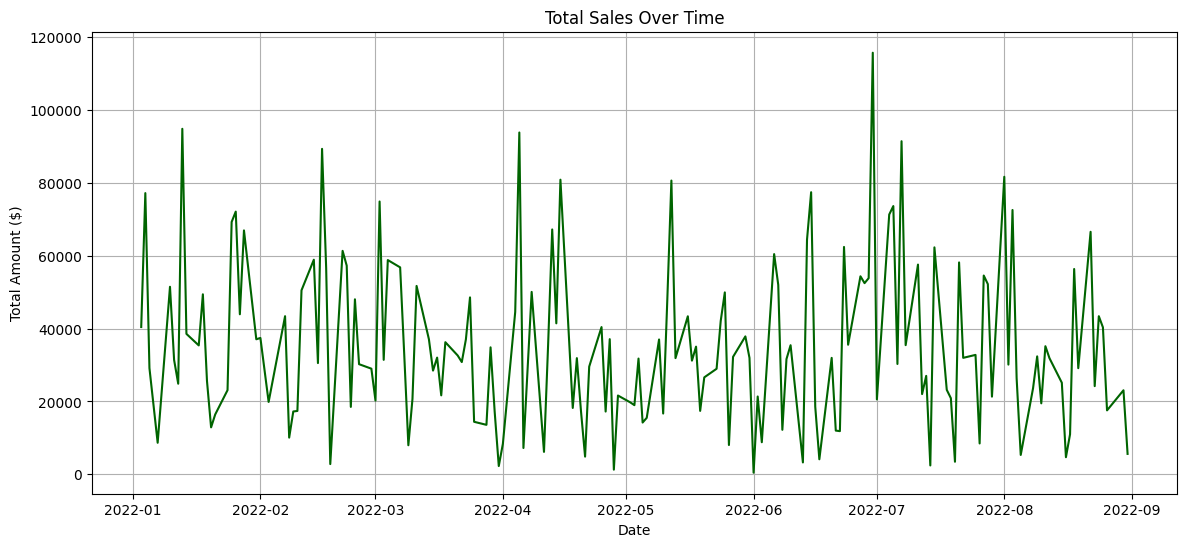

In [11]:
sales_by_date = df.groupby('Date')['Amount'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_by_date, x='Date', y='Amount', color='darkgreen')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount ($)')
plt.grid(True)
plt.show()

## Product Preference Analysis

### Top selling products

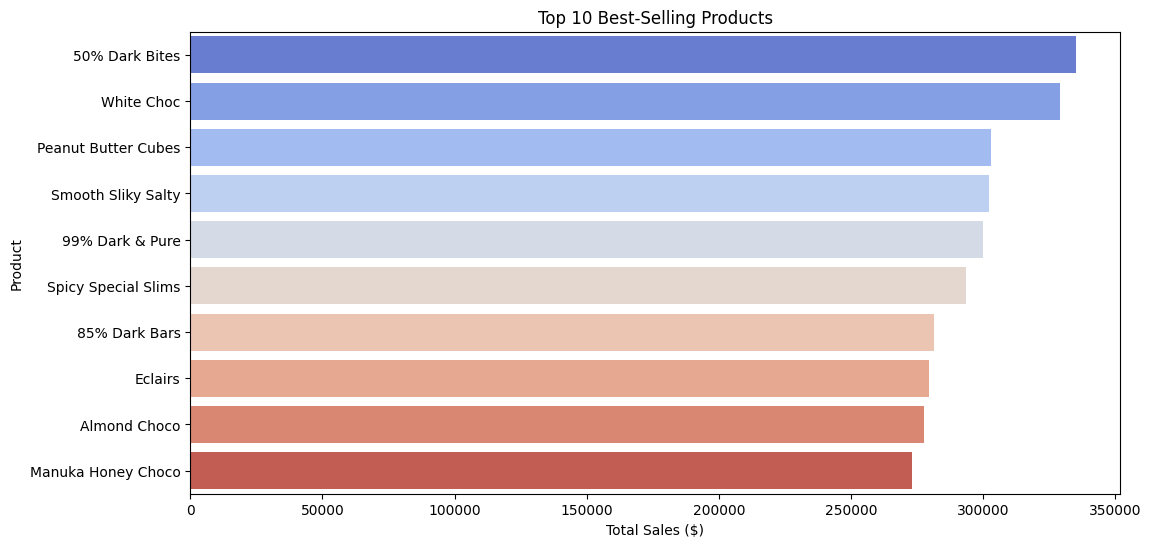

In [12]:
top_products = df.groupby('Product')['Amount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='coolwarm')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Total Sales ($)')
plt.ylabel('Product')
plt.show()

### Average sales per product

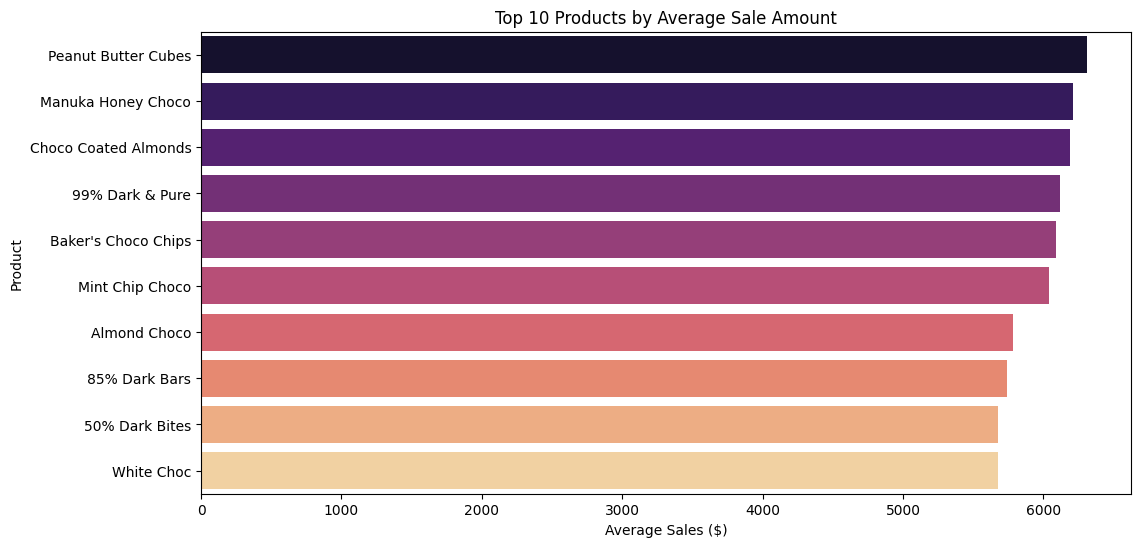

In [13]:
avg_sales_product = df.groupby('Product')['Amount'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_sales_product.values, y=avg_sales_product.index, palette='magma')
plt.title('Top 10 Products by Average Sale Amount')
plt.xlabel('Average Sales ($)')
plt.ylabel('Product')
plt.show()

## Shipping & Logistics Analysis

### Average boxes shipped per country

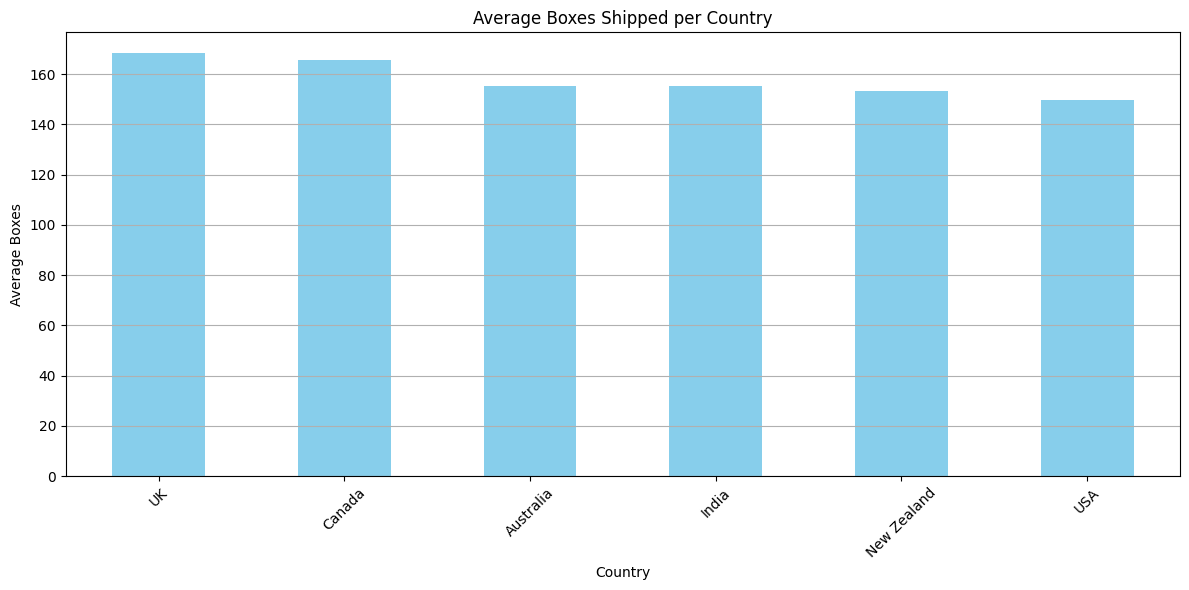

In [14]:
avg_boxes_country = df.groupby('Country')['Boxes Shipped'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
avg_boxes_country.plot(kind='bar', color='skyblue')
plt.title('Average Boxes Shipped per Country')
plt.ylabel('Average Boxes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Scatter plot: Boxes vs Amount

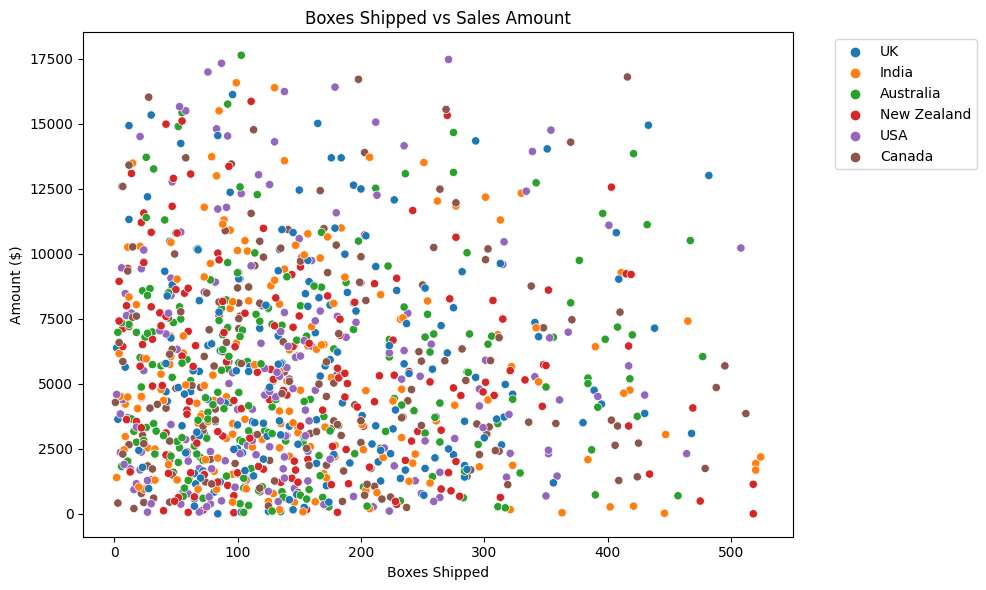

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Boxes Shipped', y='Amount', hue='Country')
plt.title('Boxes Shipped vs Sales Amount')
plt.xlabel('Boxes Shipped')
plt.ylabel('Amount ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Sales Representative Performance

### Total Sales Person

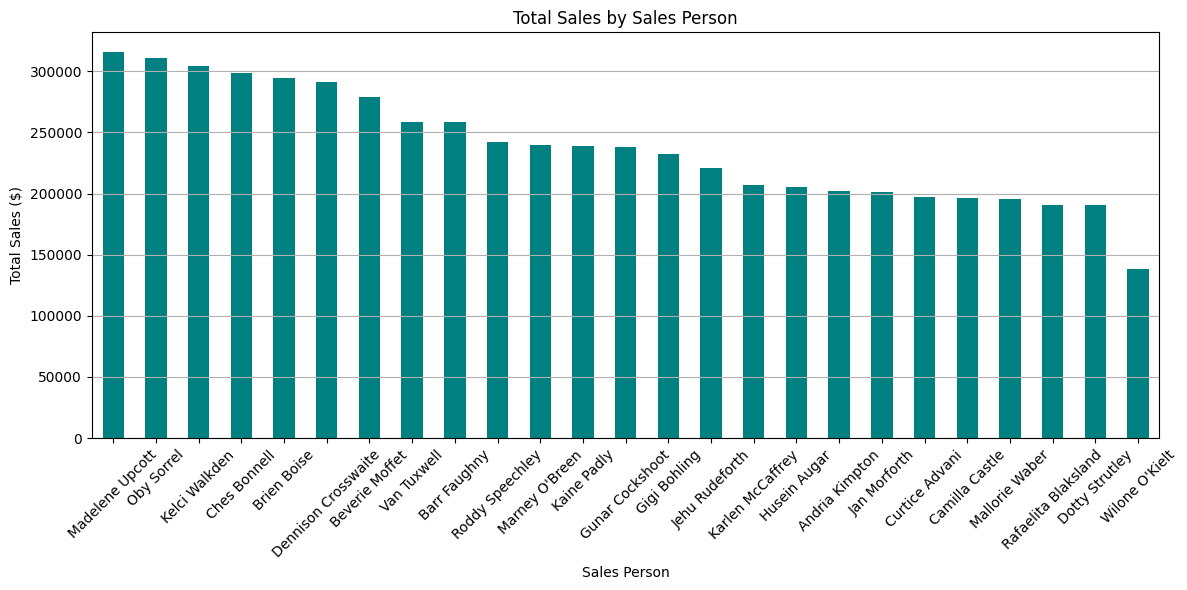

In [16]:
sales_by_rep = df.groupby('Sales Person')['Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sales_by_rep.plot(kind='bar', color='teal')
plt.title('Total Sales by Sales Person')
plt.xlabel('Sales Person')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Calculate average boxes shipped by each sales person

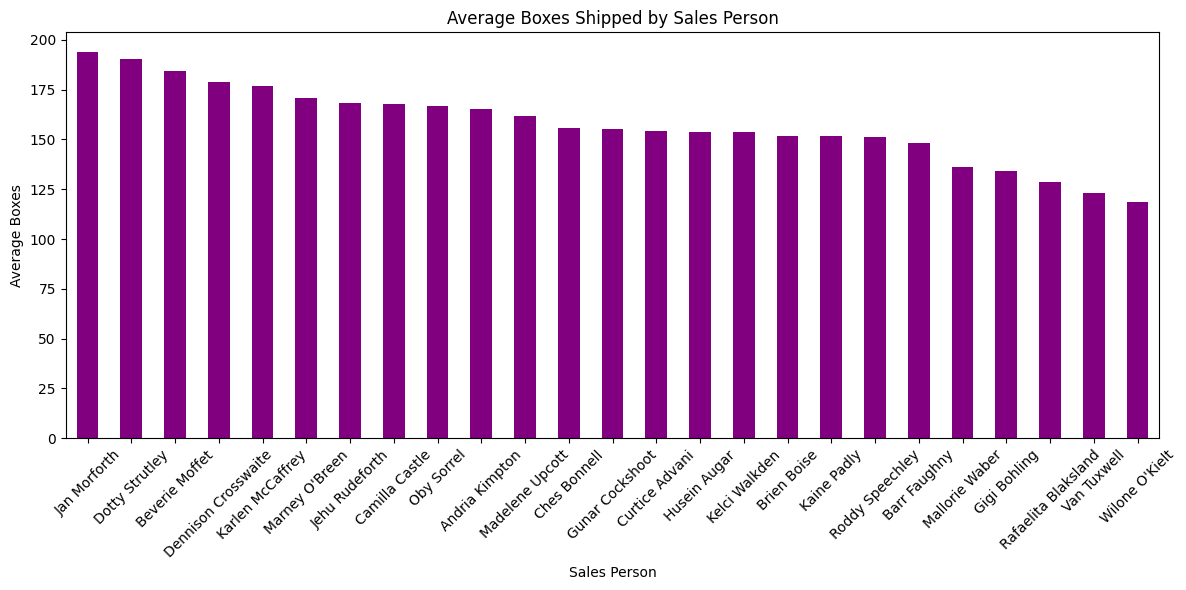

In [17]:
avg_boxes_rep = df.groupby('Sales Person')['Boxes Shipped'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
avg_boxes_rep.plot(kind='bar', color='purple')
plt.title('Average Boxes Shipped by Sales Person')
plt.ylabel('Average Boxes')
plt.xlabel('Sales Person')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Boxplot: Sales Amount Distribution per Sales Person

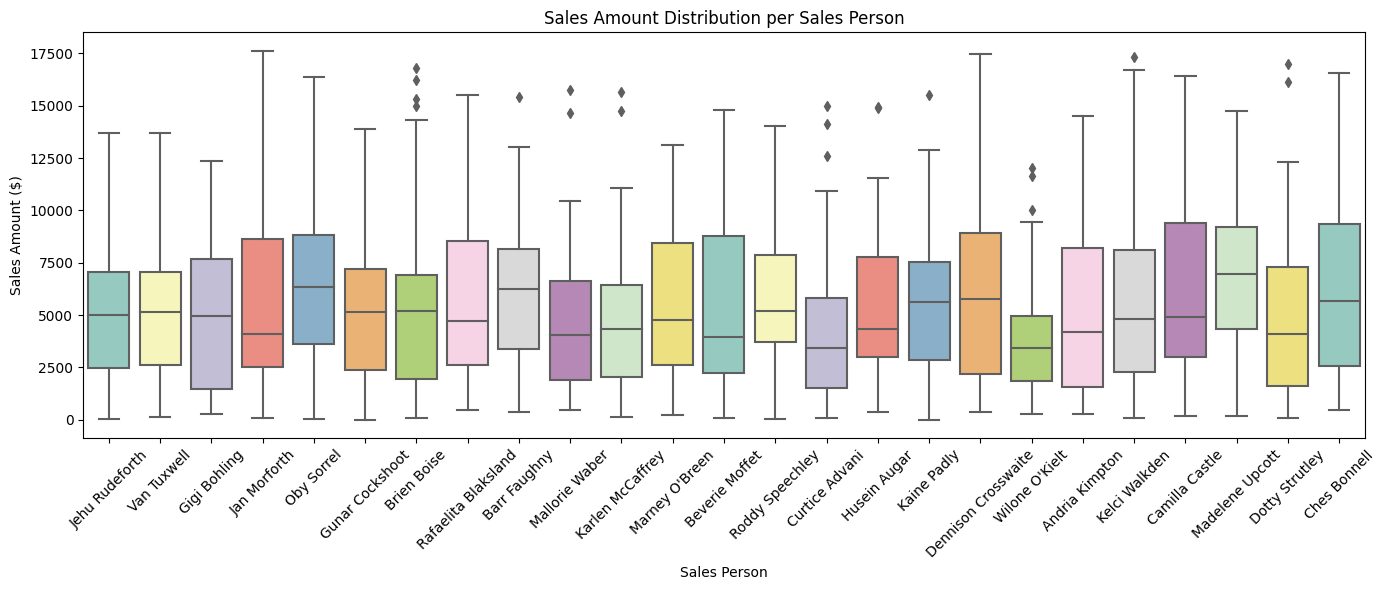

In [18]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='Sales Person', y='Amount', palette='Set3')
plt.title('Sales Amount Distribution per Sales Person')
plt.xlabel('Sales Person')
plt.ylabel('Sales Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Seasonality Analysis – Monthly Sales Trends

### 1. Convert Date column to datetime format

In [19]:
df['Date'] = pd.to_datetime(df['Date'])

### 2. Create a 'Month' column in Year-Month format

In [20]:
df['Month'] = df['Date'].dt.to_period('M')

### 3. Calculate total sales per month

In [21]:
monthly_sales = df.groupby('Month')['Amount'].sum()

### 4. Plot monthly sales as a line chart

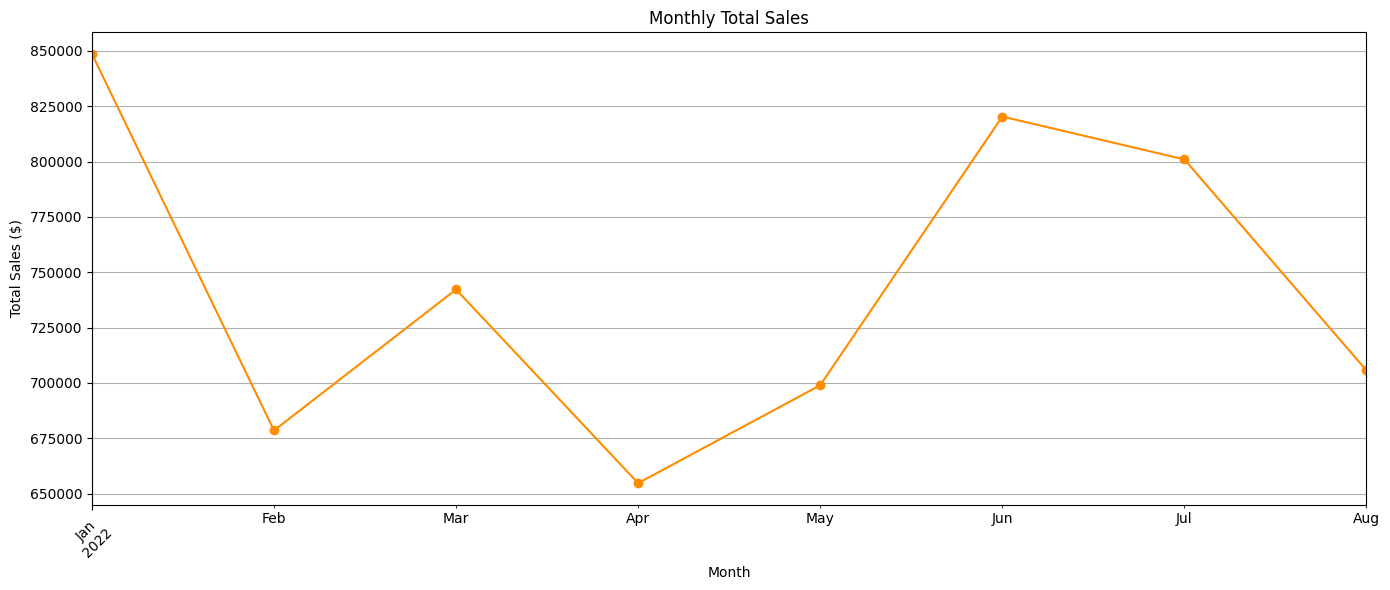

In [22]:
plt.figure(figsize=(14,6))
monthly_sales.plot(marker='o', color='darkorange')
plt.title('Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5. Convert PeriodIndex to DatetimeIndex for decomposition

In [23]:
monthly_sales_indexed = monthly_sales.copy()
monthly_sales_indexed.index = monthly_sales_indexed.index.to_timestamp()

### 6. Apply seasonal decomposition (additive model, period = 12 months)

In [24]:
result = seasonal_decompose(monthly_sales_indexed, model='additive', period=4)

### 7. Visualize the components: Trend, Seasonal, and Residual

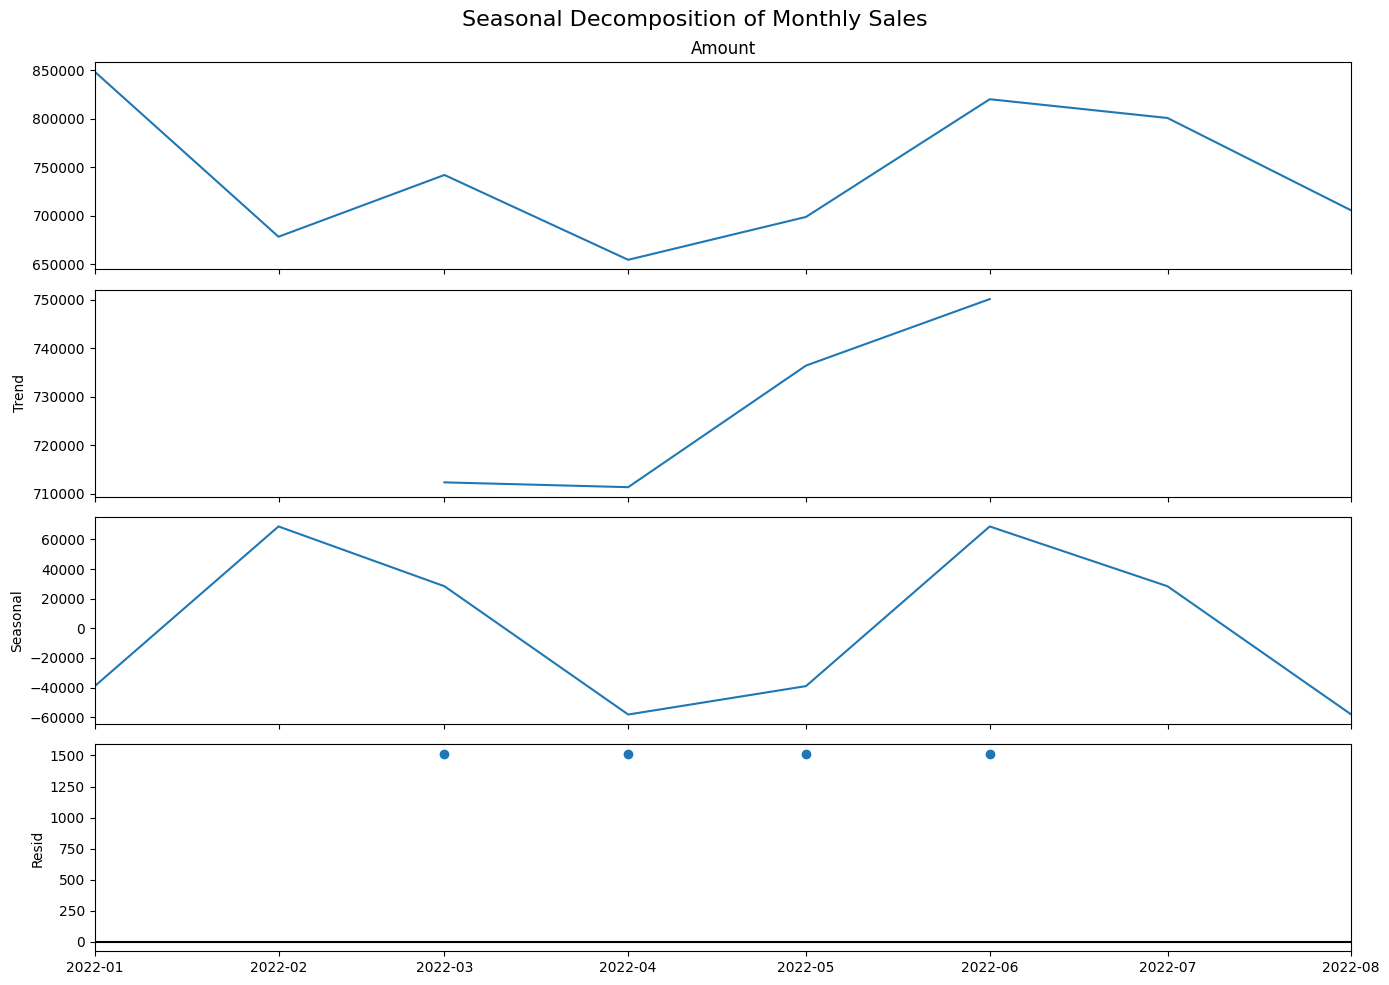

In [25]:
plt.rcParams.update({'figure.figsize': (14, 10)})
result.plot()
plt.suptitle("Seasonal Decomposition of Monthly Sales", fontsize=16)
plt.tight_layout()
plt.show()

# Classification Model 

## Step 1: Create a binary classification target

In [26]:
threshold = df['Amount'].median()
df['High_Sales'] = (df['Amount'] > threshold).astype(int)

## Step 2: Feature Engineering

In [27]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

### One-Hot Encoding for categorical variables

In [28]:
df_encoded = pd.get_dummies(df, columns=['Sales Person', 'Country', 'Product'], drop_first=True)

## Step 3: Prepare Features and Target

In [29]:
X = df_encoded.drop(['Amount', 'High_Sales', 'Date'], axis=1)
y = df_encoded['High_Sales']

### Train/Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=537)


## Step 4: Build and Train the Model

In [31]:
clf = RandomForestClassifier(n_estimators=100, random_state=537)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=537)

## Step 5: Evaluate the Model

In [32]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.49767441860465117

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.45      0.49       115
           1       0.47      0.55      0.50       100

    accuracy                           0.50       215
   macro avg       0.50      0.50      0.50       215
weighted avg       0.50      0.50      0.50       215



# Time Series Forecasting using Facebook Prophet

## Step 1: Prepare the DataFrame for Prophet

In [33]:
df_prophet = df[['Date', 'Amount']].copy()
df_prophet = df_prophet.groupby('Date').sum().reset_index()
df_prophet.columns = ['ds', 'y']

## Step 2: Initialize the Model

In [34]:
model = Prophet()

## Step 3: Fit the Model

In [35]:
model.fit(df_prophet)

13:02:17 - cmdstanpy - INFO - Chain [1] start processing
13:02:17 - cmdstanpy - INFO - Chain [1] done processing


## Step 4: Create Future DataFrame for 3 months ahead

In [36]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

## Step 5: Plot the Forecast

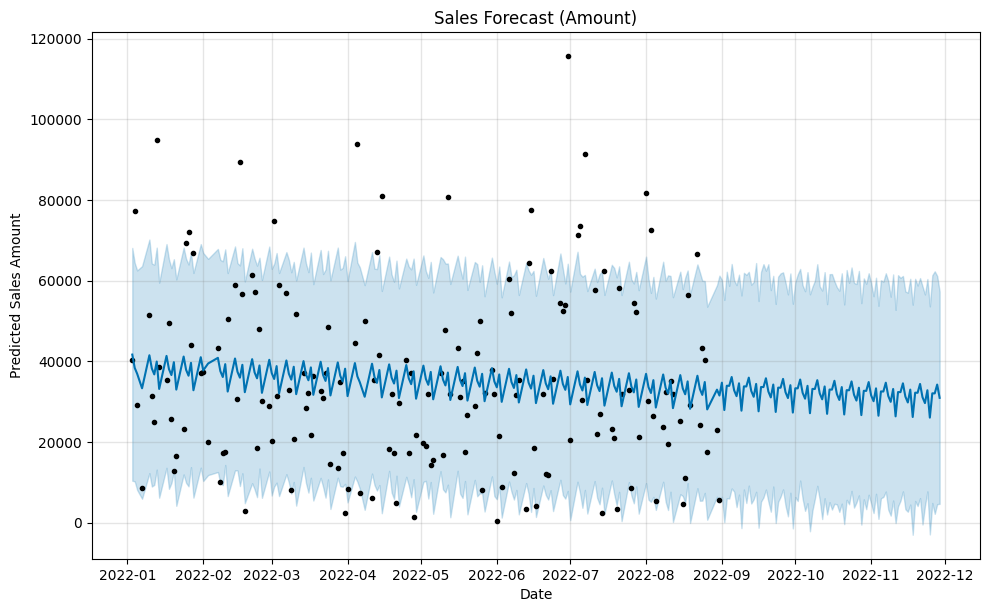

In [37]:
fig1 = model.plot(forecast)
plt.title("Sales Forecast (Amount)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales Amount")
plt.show()

## Step 6: Decompose Forecast Components

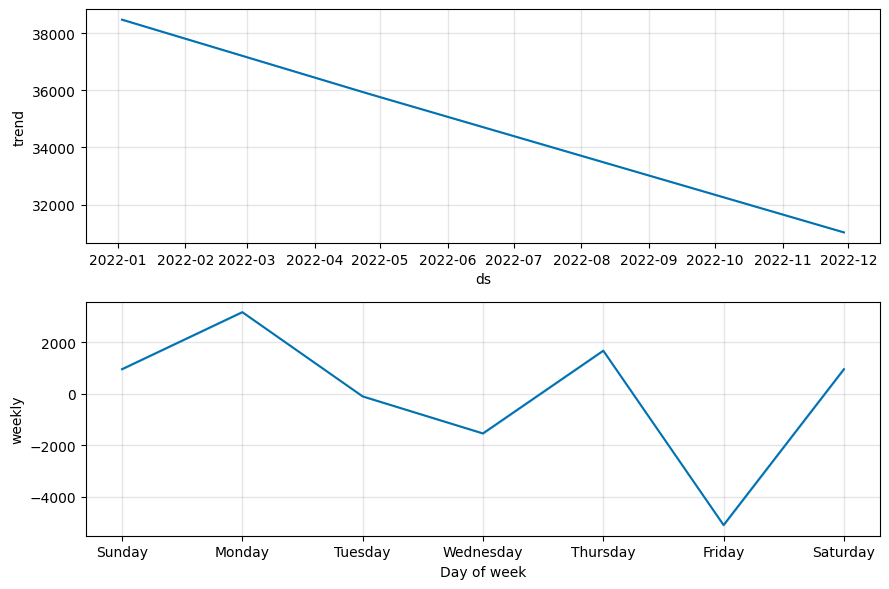

In [38]:
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

#  Insight Generation & Business Recommendations

## 1. Most Profitable Countries (Total Sales)

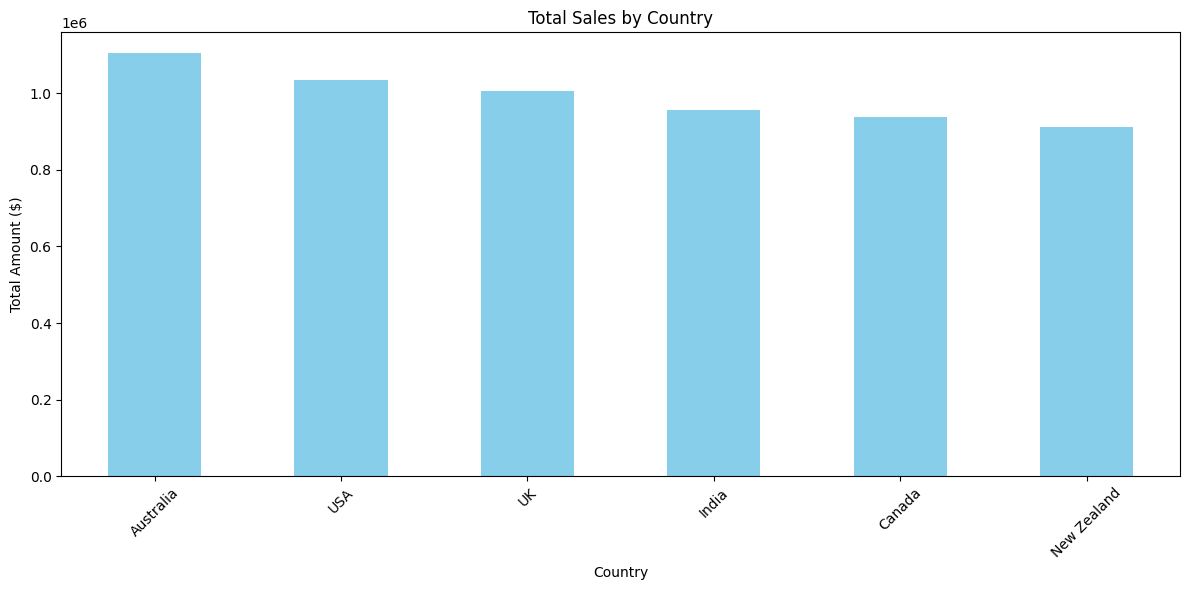

In [39]:
sales_by_country = df.groupby('Country')['Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sales_by_country.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Country')
plt.ylabel('Total Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. Most Efficient Sales Representatives

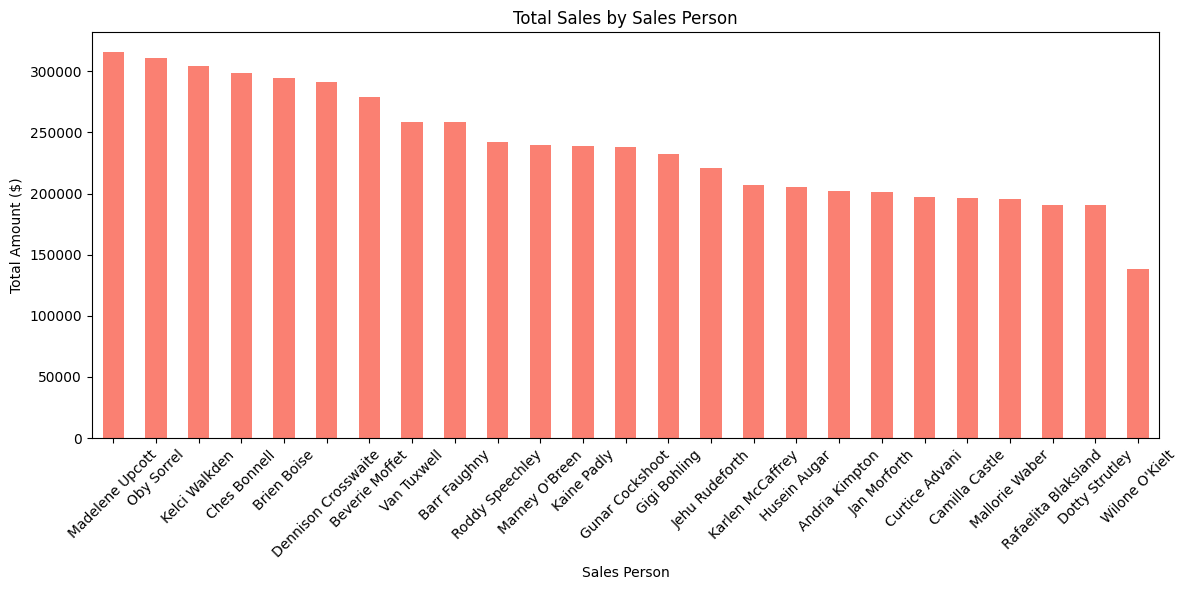

In [40]:
sales_by_rep = df.groupby('Sales Person')['Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sales_by_rep.plot(kind='bar', color='salmon')
plt.title('Total Sales by Sales Person')
plt.ylabel('Total Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Most Popular Products

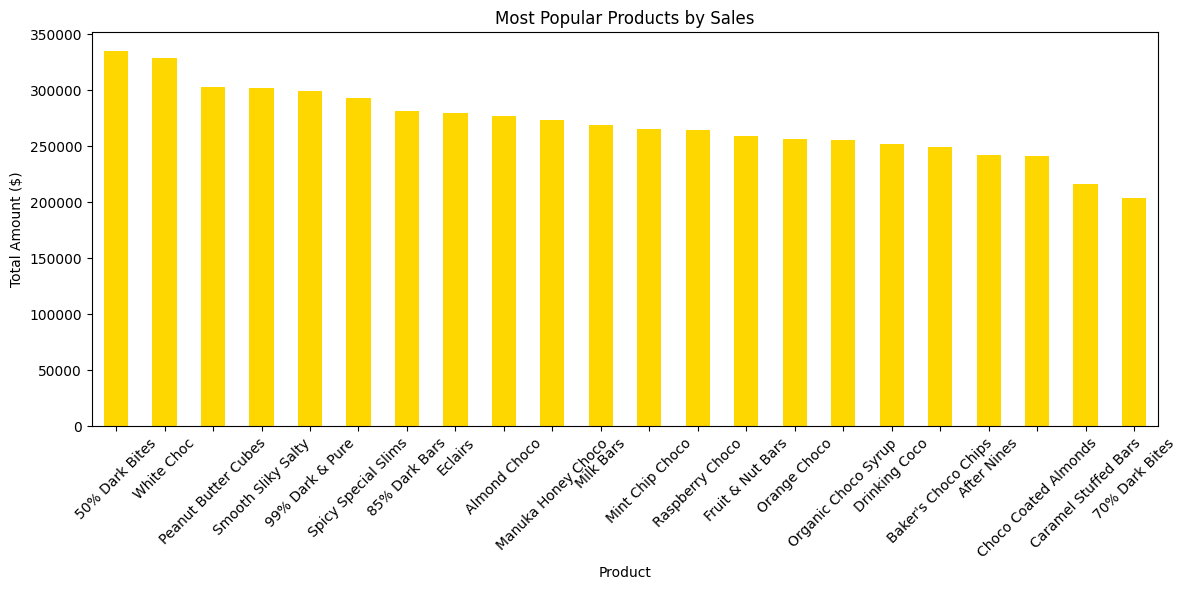

In [41]:
top_products = df.groupby('Product')['Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
top_products.plot(kind='bar', color='gold')
plt.title('Most Popular Products by Sales')
plt.ylabel('Total Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Product Combination Preference

### Get product combinations by customer per day (if possible)

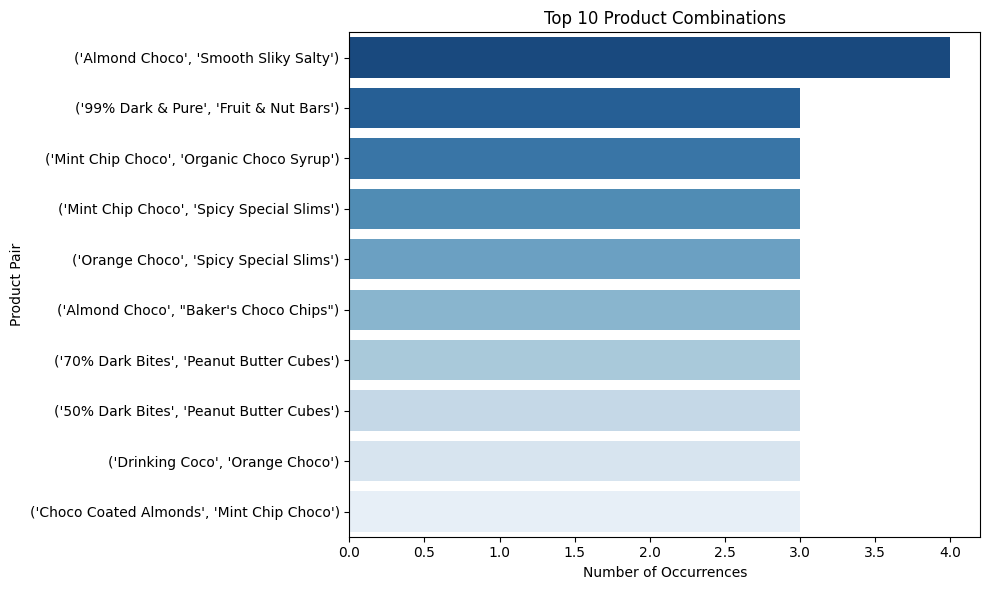

In [42]:
combo_df = df.groupby(['Date', 'Sales Person'])['Product'].apply(lambda x: list(x)).reset_index()
combinations_counter = Counter()

for products in combo_df['Product']:
    if len(products) > 1:
        combos = combinations(sorted(set(products)), 2)
        combinations_counter.update(combos)

top_combos = pd.DataFrame(combinations_counter.most_common(10), columns=['Product Pair', 'Frequency'])

plt.figure(figsize=(10,6))
sns.barplot(data=top_combos, x='Frequency', y=top_combos['Product Pair'].astype(str), palette='Blues_r')
plt.title('Top 10 Product Combinations')
plt.xlabel('Number of Occurrences')
plt.ylabel('Product Pair')
plt.tight_layout()
plt.show()

## 5. Monthly Sales Trend for Seasonality

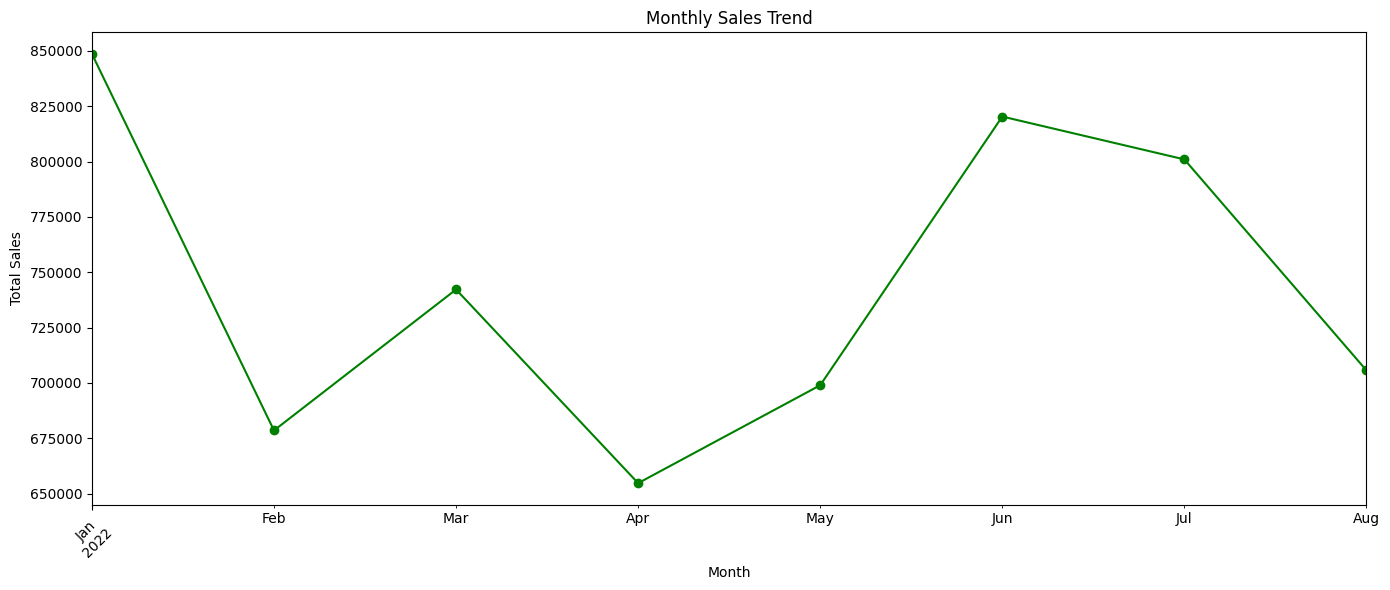

In [43]:
df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Amount'].sum()

plt.figure(figsize=(14,6))
monthly_sales.plot(marker='o', linestyle='-', color='green')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Business Recommendations 

### 1. Most profitable country

In [44]:
top_country = sales_by_country.idxmax()
top_country_amount = sales_by_country.max()
print(f"→ {top_country} has the highest total sales: ${top_country_amount:,.2f}.")

→ Australia has the highest total sales: $1,103,963.00.


### 2. Best Sales Person

In [45]:
top_rep = sales_by_rep.idxmax()
print(f"→ Top sales representative is {top_rep}.")

→ Top sales representative is Madelene Upcott.


### 3. Top Selling Product

In [46]:
top_product = top_products.idxmax()
print(f"→ The most popular product is: {top_product}.")

→ The most popular product is: 50% Dark Bites.


### 4. Suggested Marketing Strateg

In [47]:
print("→ Consider promoting the top 3 product combinations together during seasonal campaigns.")

→ Consider promoting the top 3 product combinations together during seasonal campaigns.


### 5. Seasonal Suggestion

In [48]:
peak_month = monthly_sales.idxmax().strftime('%B %Y')
print(f"→ Highest sales observed in {peak_month}. You can increase production or launch campaigns in this period.")


→ Highest sales observed in January 2022. You can increase production or launch campaigns in this period.


### 6. Logistics Suggestion

In [49]:
avg_boxes_country = df.groupby('Country')['Boxes Shipped'].mean().sort_values(ascending=False)
low_efficiency_country = avg_boxes_country.idxmin()
print(f"→ Logistics improvement is needed in {low_efficiency_country}, where the average boxes per sale is lowest.")


→ Logistics improvement is needed in USA, where the average boxes per sale is lowest.



### **Project Summary: Chocolate Sales Analysis & Forecasting**

In this project, we worked with a chocolate sales dataset to gain insights about sales performance, forecast future sales, and provide strategic business recommendations. The overall workflow was broken down into the following key steps:

---

#### 1. Data Understanding & Cleaning

- **Data Loading and Initial Inspection:**  
  We loaded the "https://github.com/Mosaad2010-star/Chocolate-Market-Analysis/blob/main/Chocolate%20Sales.csv?raw=true" file which contains key columns such as *Sales Person, Country, Product, Date, Amount,* and *Boxes Shipped*. We started by examining the data structure and checking for any inconsistencies.

- **Data Cleaning:**  
  - **Amount Column:** The dollar sign (“$”) and commas in the *Amount* column were removed and the values were converted into a numeric (float) format.
  - **Date Conversion:** The *Date* column was converted into the proper datetime format for time-based analyses.
  - **Numeric Conversion:** The *Boxes Shipped* column was converted to a numeric type, ensuring any non-numeric entries were handled.
  - **Handling Missing Values:** Missing data was handled by applying appropriate strategies like forward-filling or dropping incomplete rows.
  - **Outlier Removal:** Using the z-score method, outliers in the *Amount* and *Boxes Shipped* columns were identified and removed to ensure a robust analysis.
  - **Feature Engineering:** Additional time-based features (year, month, day, weekday) were extracted from the *Date* column, and categorical variables (Sales Person, Country, Product) were encoded for further analysis.

---

#### 2. Exploratory Data Analysis (EDA)

- **Sales Distribution Over Time:**  
  A line chart was created to visualize the trend of total sales over time. This helped in identifying overall sales trends and seasonal fluctuations.

- **Country-Based Analysis:**  
  Total sales were aggregated by country and visualized using bar charts (and a choropleth map in earlier steps, though later analysis was done with Matplotlib/Seaborn). This analysis identified which countries contributed most to the sales revenue.

- **Product Preference Analysis:**  
  The analysis included the ranking of products based on total sales and average sales amounts. Bar charts showed both the top-selling products as well as products with the highest average sale amount.

- **Shipping & Logistics Analysis:**  
  The average number of boxes shipped per country was calculated, and a scatter plot was used to examine the relationship between boxes shipped and sales amount. This step helped to understand logistics performance in relation to sales.

- **Sales Person Performance:**  
  Sales performance was evaluated by grouping data by the sales person. Total sales and average boxes shipped per sales representative were visualized using bar plots and boxplots, providing insights into individual performance.

- **Seasonality Analysis:**  
  Sales were aggregated on a monthly basis to understand seasonal trends. A line plot highlighted the monthly sales pattern, and seasonal decomposition (when there was sufficient data) was applied to separate the trend, seasonal, and residual components.

---

#### 3. Predictive Modeling (Machine Learning)

- **Regression Modeling for Sales Forecasting:**  
  For predicting the actual sales amount (*Amount*), various regression techniques were applied:
  - **Linear Regression**
  - **Random Forest Regressor**
  - **XGBoost Regressor**

  The models were evaluated using performance metrics such as the R² score.

- **Classification Modeling:**  
  To classify each transaction into “High Sales” vs. “Low Sales” categories, a binary target was created based on the median sales amount. Models such as Logistic Regression and RandomForestClassifier (as a substitute for LightGBM) were implemented. Their performance was evaluated by accuracy score and classification reports.

---

#### 4. Time Series Forecasting

- **Forecasting Using Facebook Prophet:**  
  The historical daily sales data was reshaped to fit Prophet's requirements (columns ‘ds’ for date and ‘y’ for the sales amount). The Prophet model was used to forecast future sales (e.g., for the next 3 months), and the predictions were visualized. The forecast also included the decomposition of components like trend and seasonality, which help in understanding the underlying patterns.

---

#### 5. Insight Generation & Business Recommendations

- **Generating Insights:**  
  Detailed insights were derived from the visualizations and model outputs:
  - **Most Profitable Countries:** Identified which country generated the highest total sales.
  - **Top Sales Representatives:** Evaluated the performance of individual sales persons.
  - **Top-Selling Products:** Determined which products were most popular.
  - **Product Combination Analysis:** Evaluated combinations of products that tend to sell together, suggesting potential cross-promotional opportunities.
  - **Seasonality Trends:** Analyzed monthly sales trends to detect peak periods, providing guidance for seasonal promotions or production planning.

- **Business Recommendations:**  
  Based on the analytics:
  - Invest more in the highest performing markets and representatives.
  - Bundle top-selling products or combinations in targeted promotional campaigns.
  - Adjust stock and logistic plans in anticipation of seasonal peaks.
  - Optimize supply chain processes in regions with lower logistics efficiency.

---

# Thank you for taking the time to review my work. I would be very happy if you could upvote! 😊